# Imports

In [1]:
import numpy as np
import tensorflow as tf 
import pandas as pd
import os
import certifi
from PIL import Image
import os
import keras
from keras.metrics import F1Score 
import matplotlib.pyplot as plt
import random
import gc
from keras.models import Sequential
from keras import layers 
from keras import Model 

from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback
from sklearn.metrics import f1_score
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("Metal is available and working correctly.")
else:
    print("Metal is not available or not working correctly.")

Metal is available and working correctly.


# GPT O Fuled

## Parameters

In [3]:
resolution_horizontal = 300
resolution_vertical = 200 
color_channels = 1


## Data Loading & Preprocessing

### Loading and Helper Functions

In [4]:
def load_and_preprocess_images(image_paths, resolution_horizontal, resolution_vertical, normalization=True, grayscale=False):
    """
    Loads and preprocesses images from the given list of image paths.
    Images are resized to the specified resolution and optionally normalized.

    Parameters:
        image_paths (list): List of image file paths.
        resolution_horizontal (int): Desired image width.
        resolution_vertical (int): Desired image height.
        normalization (bool): Whether to normalize pixel values to [0, 1].

    Returns:
        np.array: Array of preprocessed images.
    """
    images = []
    for path in image_paths:
        try:
            # Open the image file
            with Image.open(path) as img:
                # Convert image to RGB (in case it's grayscale or RGBA)
                if grayscale == False:
                    img = img.convert('RGB')
                if grayscale == True:
                    img = img.convert('L')
                # Resize the image to the desired resolution
                img = img.resize((resolution_horizontal, resolution_vertical))
                # Convert the image to a numpy array
                img_array = np.array(img)
                images.append(img_array)
        except Exception as e:
            print(f"Error loading image {path}: {e}")
    # Convert list to numpy array
    images = np.array(images)
    if normalization:
        # Normalize pixel values to [0, 1]
        images = images / 255.0
    return images


In [5]:
# Create y_fraud array with dtype int8 to save memory
def create_labels(num_fraud, num_non_fraud):
    y_fraud = np.zeros((num_fraud, 2), dtype=np.int8)
    for i in range(num_fraud):
        y_fraud[i] = [1, 0]
        y_fraud 


    # Create y_non_fraud array with dtype int8 to save memory
    y_non_fraud = np.zeros((num_non_fraud, 2), dtype=np.int8)
    for i in range(num_non_fraud):
        y_non_fraud[i] = [0, 1]

    return np.concatenate((y_fraud, y_non_fraud))

    



In [6]:
def get_all_image_paths(directory):
    """
    Retrieves all image file paths from the specified directory.
    
    Parameters:
        directory (str): Path to the directory containing images.
        
    Returns:
        list: List of image file paths.
    """
    image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')  # Supported image formats
    all_images = [os.path.join(directory, img) for img in os.listdir(directory)
                 if os.path.isfile(os.path.join(directory, img)) and img.lower().endswith(image_extensions)]
    return all_images






In [7]:
class F1ScoreCallback(Callback):
    def __init__(self, validation_data):
        super(F1ScoreCallback, self).__init__()
        self.validation_data = validation_data
        self.best_f1 = -np.Inf
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), axis=1)
        val_true = np.argmax(self.validation_data[1], axis=1)
        current_f1 = f1_score(val_true, val_predict, average='macro')
        print(f" — val_f1_score: {current_f1:.4f}")
        if current_f1 > self.best_f1:
            self.best_f1 = current_f1
            self.best_weights = self.model.get_weights()
            print(f"New best F1 score: {self.best_f1:.4f}")


In [8]:
def create_labels(num_fraud, num_non_fraud):
    y_fraud = np.zeros((num_fraud, 2), dtype=np.int8)
    for i in range(num_fraud):
        y_fraud[i] = [1, 0]
        y_fraud 


    # Create y_non_fraud array with dtype int8 to save memory
    y_non_fraud = np.zeros((num_non_fraud, 2), dtype=np.int8)
    for i in range(num_non_fraud):
        y_non_fraud[i] = [0, 1]

    return np.concatenate((y_fraud, y_non_fraud))


### Training Function

In [9]:
def train_model_in_batches(model, 
                           number_of_fraud, 
                           number_of_non_fraud, 
                           epochs_training, 
                          epochs_fit, 
                          batch_size, 
                          resolution_horizontal, 
                          resolution_vertical, 
                          validation_split, 
                          filepath_save,
                          normalization = True,
                          grayscale = False):
    """
    Trains the given model using batches of Fraud and Non-Fraud images to manage memory usage.
    Incorporates class weights to handle class imbalance.
    Saves the best performing model of each iteration based on Validation Accuracy by overwriting
    the previously saved model.
    
    Parameters:
        model (keras.Model): The neural network model to train.
        number_of_fraud (int): Number of Fraud images to load per training iteration.
        number_of_non_fraud (int): Number of Non-Fraud images to load per training iteration.
        epochs_training (int): Number of training iterations.
        epochs_fit (int): Number of epochs per model.fit call.
        batch_size (int): Batch size for training.
        resolution_horizontal (int): Width to resize images.
        resolution_vertical (int): Height to resize images.
        validation_split (float): Fraction of data to use for validation.
        filepath_save (str): Filepath to save the best model.
        
    Returns:
        keras.Model: The trained model with the best validation performance.
    """
    # Define directories
    fraud_dir = "car_images/train/Fraud"
    non_fraud_dir = "car_images/train/Non-Fraud"
    
    # Get all image paths once to avoid repeated disk access
    fraud_image_paths_all = get_all_image_paths(fraud_dir)
    non_fraud_image_paths_all = get_all_image_paths(non_fraud_dir)
    total_fraud_images = len(fraud_image_paths_all)
    total_non_fraud_images = len(non_fraud_image_paths_all)
    
    print(f"Total Fraud Images Available: {total_fraud_images}")
    print(f"Total Non-Fraud Images Available: {total_non_fraud_images}")
    
    # Define the ModelCheckpoint callback
    checkpoint = ModelCheckpoint(filepath=filepath_save, monitor='val_accuracy', 
                                 save_best_only=True, verbose=1, mode='max')
    
    for training_iteration in range(1, epochs_training + 1):
        print(f"\n=== Training Iteration {training_iteration}/{epochs_training} ===")
        
        # Step 1: Randomly select image paths for this iteration
        selected_fraud = random.sample(fraud_image_paths_all, min(number_of_fraud, total_fraud_images))
        selected_non_fraud = random.sample(non_fraud_image_paths_all, min(number_of_non_fraud, total_non_fraud_images))
        
        print(f"Selected {len(selected_fraud)} Fraud images and {len(selected_non_fraud)} Non-Fraud images.")
        
        # Step 2: Load and preprocess images
        fraud_images = load_and_preprocess_images(
            selected_fraud, resolution_horizontal, resolution_vertical, normalization=normalization, grayscale= grayscale
        )
        non_fraud_images = load_and_preprocess_images(
            selected_non_fraud, resolution_horizontal, resolution_vertical, normalization=normalization, grayscale= grayscale,
        )        
        
        
        # Step 5: Combine data and labels
        data = np.concatenate((fraud_images, non_fraud_images), axis=0)
        labels = create_labels(len(fraud_images), len(non_fraud_images))
        
        print(f"Data shape: {data.shape}, Labels shape: {labels.shape}")
        
        

        # Step 9: Train the model with class weights and ModelCheckpoint
        history = model.fit(
            x = data, 
            y = labels, 
            epochs=epochs_fit, 
            batch_size=batch_size, 
            validation_split=validation_split,
            callbacks = [checkpoint],
            verbose=1
       ) 
        
        # Step 10: Clean up to free memory
        del selected_fraud, selected_non_fraud, fraud_images, non_fraud_images, data, labels, history
        gc.collect()
    
    # After all iterations, load the best model saved by ModelCheckpoint
    if os.path.exists(filepath_save):
        model = tf.keras.models.load_model(filepath_save)
        print(f"\nTraining complete. Best Validation Accuracy achieved and model saved to: {filepath_save}")
    else:
        print("\nTraining complete. No model was saved.")
    
    return model


### Evalation Functions

In [10]:
import numpy as np
import os
from PIL import Image
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from keras.utils import to_categorical

def evaluate_model(model, resolution_horizontal, resolution_vertical, normalization=False):
    """
    Evaluates the trained model on test data by loading test images,
    preprocessing them, making predictions, and computing evaluation metrics.
    
    Parameters:
        model (keras.Model): The trained neural network model to evaluate.
        resolution_horizontal (int): Width to resize test images.
        resolution_vertical (int): Height to resize test images.
        normalization (bool): Whether to normalize pixel values to [0, 1].
        
    Returns:
        dict: Dictionary containing the confusion matrix and other KPIs.
    """
    # Define test directories
    fraud_test_dir = "car_images/test/Fraud"
    non_fraud_test_dir = "car_images/test/Non-Fraud"

    print("=== Evaluation Process Started ===")

    # Step 1: Retrieve all test image paths
    print("\nRetrieving test image paths...")
    fraud_image_paths = get_all_image_paths(fraud_test_dir)
    non_fraud_image_paths = get_all_image_paths(non_fraud_test_dir)

    num_fraud = len(fraud_image_paths)
    num_non_fraud = len(non_fraud_image_paths)

    print(f"Number of Fraud Test Images: {num_fraud}")
    print(f"Number of Non-Fraud Test Images: {num_non_fraud}")

    # Step 2: Load and preprocess images
    print("\nLoading and preprocessing Fraud test images...")
    fraud_images = load_and_preprocess_images(
        fraud_image_paths, resolution_horizontal, resolution_vertical, normalization=normalization
    )

    print("Loading and preprocessing Non-Fraud test images...")
    non_fraud_images = load_and_preprocess_images(
        non_fraud_image_paths, resolution_horizontal, resolution_vertical, normalization=normalization
    )

    # Step 3: Create labels (One-Hot Encoded)
    print("\nCreating labels for test data...")
    labels_one_hot = create_labels(num_fraud, num_non_fraud)  # Returns one-hot encoded labels

    # Step 4: Combine data and labels
    print("\nCombining and shuffling test data...")
    data = np.concatenate((fraud_images, non_fraud_images), axis=0)
    labels = labels_one_hot  # Already one-hot encoded

    # Shuffle data and labels together
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    data = data[indices]
    labels = labels[indices]

    print(f"Total Test Samples: {data.shape[0]}")
    print(f"Data Shape: {data.shape}")
    print(f"Labels Shape: {labels.shape}")

    # Step 5: Convert One-Hot Labels to Integer Labels
    labels_int = np.argmax(labels, axis=1)

    # Step 6: Make predictions
    print("\nMaking predictions on test data...")
    predictions = model.predict(data, verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)

    # Step 7: Compute Confusion Matrix and KPIs
    print("\nComputing evaluation metrics...")
    cm = confusion_matrix(labels_int, predicted_classes)
    report = classification_report(labels_int, predicted_classes, target_names=['Fraud', 'Non-Fraud'], output_dict=True)
    accuracy = accuracy_score(labels_int, predicted_classes)
    precision = precision_score(labels_int, predicted_classes, pos_label=0)  # Assuming 'Fraud' is label 0
    recall = recall_score(labels_int, predicted_classes, pos_label=0)
    f1 = f1_score(labels_int, predicted_classes, pos_label=0)

    # Display Confusion Matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fraud', 'Non-Fraud'], yticklabels=['Fraud', 'Non-Fraud'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Display Classification Report
    print("\nClassification Report:")
    print(classification_report(labels_int, predicted_classes, target_names=['Fraud', 'Non-Fraud']))

    # Print Accuracy, Precision, Recall, F1-Score
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Fraud): {precision:.4f}")
    print(f"Recall (Fraud): {recall:.4f}")
    print(f"F1-Score (Fraud): {f1:.4f}")

    # Step 8: Clean up to free memory
    del fraud_image_paths, non_fraud_image_paths, fraud_images, non_fraud_images, data, labels, predictions, predicted_classes, labels_one_hot, labels_int
    gc.collect()

    print("\n=== Evaluation Process Completed ===")

    # Compile KPIs into a dictionary
    kpis = {
        'Confusion_Matrix': cm,
        'Classification_Report': report,
        'Accuracy': accuracy,
        'Precision_Fraud': precision,
        'Recall_Fraud': recall,
        'F1_Score_Fraud': f1
    }

    return kpis


In [11]:
import numpy as np
import os
import random
from keras.utils import to_categorical
import gc
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

def simulate_games(model, num_runs=100, images_per_game=10):
    """
    Simulates a game where the model predicts labels for a set number of images across multiple runs.
    
    Each game consists of predicting 'images_per_game' images, where each image has a 50% chance 
    of being Fraud or Non-Fraud. The function performs 'num_runs' such games and returns the 
    probability distribution of scores (0 to images_per_game correct predictions).
    
    Parameters:
        model (keras.Model): The trained neural network model to use for predictions.
        num_runs (int): Number of game simulations to perform. Default is 100.
        images_per_game (int): Number of images to predict in each game. Default is 10.
        
    Returns:
        dict: A dictionary where keys are the number of correct predictions (0-10) 
              and values are the corresponding probabilities.
    """
    # Define test directories
    fraud_test_dir = "car_images/test/Fraud"
    non_fraud_test_dir = "car_images/test/Non-Fraud"
    
    # Retrieve all test image paths
    fraud_image_paths = get_all_image_paths(fraud_test_dir)
    non_fraud_image_paths = get_all_image_paths(non_fraud_test_dir)
    
    num_fraud_test = len(fraud_image_paths)
    num_non_fraud_test = len(non_fraud_image_paths)
    
    print(f"Total Fraud Test Images: {num_fraud_test}")
    print(f"Total Non-Fraud Test Images: {num_non_fraud_test}")
    
    # Check if there are enough images to simulate the game
    if num_fraud_test == 0 or num_non_fraud_test == 0:
        print("Insufficient images in one of the test directories.")
        return {}
    
    # Retrieve model's expected input shape
    # Exclude the batch size (None)
    expected_input_shape = model.input_shape[1:]  # e.g., (400, 600, 3)
    print(f"Model's Expected Input Shape: {expected_input_shape}")
    
    # Initialize a list to store the score of each game
    game_scores = []
    
    for run in range(1, num_runs + 1):
        correct_predictions = 0  # Initialize correct prediction count for this game
        print(f"\n--- Game {run}/{num_runs} ---")
        
        for img_num in range(1, images_per_game + 1):
            # Randomly decide the true class: 0 for Fraud, 1 for Non-Fraud
            true_class = random.choice([0, 1])
            
            if true_class == 0:
                # Select a random Fraud image
                selected_image_path = random.choice(fraud_image_paths)
                true_label = [1, 0]  # One-hot encoded label for Fraud
            else:
                # Select a random Non-Fraud image
                selected_image_path = random.choice(non_fraud_image_paths)
                true_label = [0, 1]  # One-hot encoded label for Non-Fraud
            
            # Load and preprocess the image
            preprocessed_image = load_and_preprocess_image(
                selected_image_path, 
                expected_input_shape[1],  # width
                expected_input_shape[0],  # height
                normalization=True
            )
            
            # Expand dimensions to match model's input shape (1, H, W, C)
            input_image = np.expand_dims(preprocessed_image, axis=0)
            
            # Make prediction
            prediction = model.predict(input_image, verbose=0)
            predicted_class = np.argmax(prediction, axis=1)[0]
            actual_class = np.argmax(true_label)
            
            # Compare prediction to true label
            if predicted_class == actual_class:
                correct_predictions += 1
            else:
                print(f"Image {img_num}: Incorrectly predicted as {'Fraud' if predicted_class == 0 else 'Non-Fraud'}. True label: {'Fraud' if actual_class == 0 else 'Non-Fraud'}.")
        
        # Record the score for this game
        game_scores.append(correct_predictions)
        print(f"Game {run} Score: {correct_predictions}/{images_per_game}")
    
    # Calculate frequency of each possible score (0-10)
    score_counts = {score: 0 for score in range(0, images_per_game + 1)}
    for score in game_scores:
        score_counts[score] += 1
    
    # Convert counts to probabilities
    probability_distribution = {score: count / num_runs for score, count in score_counts.items()}
    
    # Display the probability distribution
    print("\n=== Probability Distribution of Correct Predictions ===")
    for score in sorted(probability_distribution.keys()):
        print(f"{score} correct predictions: {probability_distribution[score]*100:.2f}%")
    
    # Optional: Plot the distribution
    scores = list(probability_distribution.keys())
    probabilities = list(probability_distribution.values())
    
    plt.figure(figsize=(10,6))
    sns.barplot(x=scores, y=probabilities, palette="viridis")
    plt.xlabel('Number of Correct Predictions')
    plt.ylabel('Probability')
    plt.title(f'Probability Distribution of Correct Predictions Across {num_runs} Games')
    plt.ylim(0, 1)
    plt.show()
    
    return probability_distribution

def load_and_preprocess_image(image_path, resolution_horizontal, resolution_vertical, normalization=True):
    """
    Loads and preprocesses a single image from the given path.
    Resizes the image to the specified resolution and optionally normalizes pixel values.
    
    Parameters:
        image_path (str): Path to the image file.
        resolution_horizontal (int): Desired image width.
        resolution_vertical (int): Desired image height.
        normalization (bool): Whether to normalize pixel values to [0, 1].
    
    Returns:
        np.array: Preprocessed image array.
    """
    try:
        with Image.open(image_path) as img:
            img = img.convert('RGB')  # Ensure image has 3 channels
            img = img.resize((resolution_horizontal, resolution_vertical))
            img_array = np.array(img)
            if normalization:
                img_array = img_array / 255.0
            return img_array
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        # Return a black image in case of error to maintain consistency
        return np.zeros((resolution_vertical, resolution_horizontal, 3))


## Model Building & Training

### O-1 Ideas

In [12]:
# Define your model (example using a simple CNN)
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def create_model(input_shape):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(2, activation='softmax')  # Binary classification with one-hot encoding
    ])
    
    # Compile the model with F1Score metric
    f1 = F1Score(average='macro', name='f1_score')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1])
    return model

# Initialize the model
input_shape = (resolution_horizontal, resolution_vertical, 3)  # Example resolution
model = create_model(input_shape)

# Define training parameters
number_of_fraud = 300
number_of_non_fraud = 300
epochs_training = 10
epochs_fit = 8
batch_size = 32
resolution_horizontal = resolution_horizontal
resolution_vertical = resolution_vertical
validation_split = 0.2

# Train the model using the defined function
trained_model = train_model_in_batches(
    model=model,
    number_of_fraud=number_of_fraud,
    number_of_non_fraud=number_of_non_fraud,
    epochs_training=epochs_training,
    epochs_fit=epochs_fit,
    batch_size=batch_size,
    resolution_horizontal=resolution_horizontal,
    resolution_vertical=resolution_vertical,
    validation_split=validation_split
)


/Users/lucasmuller/Desktop/Githubg/Model_Creation/Beat-the-Model-Cration/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-09-24 18:56:52.659761: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-09-24 18:56:52.659791: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-09-24 18:56:52.659796: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-09-24 18:56:52.659817: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-24 18:56:52.659834: I tensorflow/core/common_

Total Fraud Images Available: 372
Total Non-Fraud Images Available: 6091

=== Training Iteration 1/10 ===
Selected 300 Fraud images and 300 Non-Fraud images.
Class Weights: {0: 1.0, 1: 1.0}


In [16]:
trained_model.save('models/trained_model.keras')

=== Evaluation Process Started ===

Retrieving test image paths...
Number of Fraud Test Images: 93
Number of Non-Fraud Test Images: 1523

Loading and preprocessing Fraud test images...
Loading and preprocessing Non-Fraud test images...

Creating labels for test data...

Combining and shuffling test data...
Total Test Samples: 1616
Data Shape: (1616, 200, 300, 3)
Labels Shape: (1616,)

Making predictions on test data...
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step

Computing evaluation metrics...


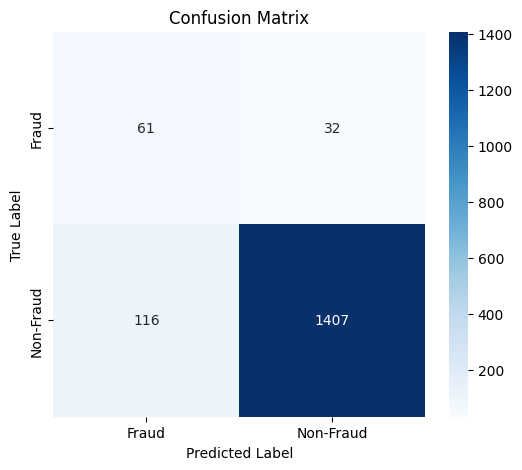


Classification Report:
              precision    recall  f1-score   support

       Fraud       0.34      0.66      0.45        93
   Non-Fraud       0.98      0.92      0.95      1523

    accuracy                           0.91      1616
   macro avg       0.66      0.79      0.70      1616
weighted avg       0.94      0.91      0.92      1616

Accuracy: 0.9084
Precision (Fraud): 0.3446
Recall (Fraud): 0.6559
F1-Score (Fraud): 0.4519

=== Evaluation Process Completed ===


{'Confusion_Matrix': array([[  61,   32],
        [ 116, 1407]]),
 'Classification_Report': {'Fraud': {'precision': 0.3446327683615819,
   'recall': 0.6559139784946236,
   'f1-score': 0.45185185185185184,
   'support': 93.0},
  'Non-Fraud': {'precision': 0.9777623349548298,
   'recall': 0.9238345370978333,
   'f1-score': 0.950033760972316,
   'support': 1523.0},
  'accuracy': 0.9084158415841584,
  'macro avg': {'precision': 0.6611975516582058,
   'recall': 0.7898742577962284,
   'f1-score': 0.700942806412084,
   'support': 1616.0},
  'weighted avg': {'precision': 0.9413260418278667,
   'recall': 0.9084158415841584,
   'f1-score': 0.9213636387271408,
   'support': 1616.0}},
 'Accuracy': 0.9084158415841584,
 'Precision_Fraud': 0.3446327683615819,
 'Recall_Fraud': 0.6559139784946236,
 'F1_Score_Fraud': 0.45185185185185184}

In [40]:
evaluate_model(model=trained_model, resolution_horizontal=300, resolution_vertical=200)

In [3]:
# Importing Modules for Model Training


from keras.models import Sequential
from keras.models import Model
from keras import layers
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, GlobalAveragePooling2D
from keras.metrics import CategoricalAccuracy
from sklearn.metrics import balanced_accuracy_score
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


## Transfer Learning (Lucas)

### VGG-19

In [20]:
# Initially I tried to freeze the layer fron the model above but my approach didnt seem to work. I didnt understand why. 
# After spending some time on that, I opted for a different approach namely reading the documentation on the Keras Website 



# Set SSL certificate file path
os.environ['SSL_CERT_FILE'] = certifi.where()

from keras.applications import VGG19

# Load InceptionV3 model without the top layer and freeze its layers
base_model_custom = VGG19(weights="imagenet", include_top=False, input_shape=(resolution_vertical, resolution_horizontal, color_channels))
base_model_custom.trainable = False



# Build the custom top layers
x = base_model_custom.output
x = layers.Conv2D(256, activation="relu", kernel_size=(2, 2), padding="VALID", name="VGG19_Conv2D_1")(x)
x = layers.BatchNormalization(name="VGG19_BatchNormalization_1")(x)
x = layers.Dropout(0.2, seed=42, name="VGG19_Dropout_2")(x)
x = layers.Conv2D(128, activation="relu", kernel_size=(2, 2), padding="VALID", name="VGG19_Conv2D_2")(x)
x = layers.BatchNormalization(name="VGG19_BatchNormalization_2")(x)
x = layers.Conv2D(64, activation="relu", kernel_size=(2, 2), padding="VALID", name="VGG19_Conv2D_3")(x)
x = layers.BatchNormalization(name="VGG19_BatchNormalization_3")(x)
x = layers.GlobalAveragePooling2D(name="VGG19_GlobalAveragePooling2D")(x)
x = layers.Flatten(name="VGG19_Flatten")(x)
predictions = layers.Dense(2, activation="sigmoid", name="VGG19_Dense")(x)

# Combine the base model with the custom top layers
VGG19_custom = Model(inputs=base_model_custom.input, outputs=predictions, name="VGG19_Model")

VGG19_custom.compile(optimizer=keras.optimizers.Adam(),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])


VGG19_custom.summary()






2024-09-25 11:23:30.476060: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-09-25 11:23:30.476093: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-09-25 11:23:30.476102: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-09-25 11:23:30.476128: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-25 11:23:30.476186: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "VGG19_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 200, 300, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 200, 300, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 100, 150, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 100, 150, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 100, 150, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 50, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 50, 75, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 50, 75, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 50, 75, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 50, 75, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 25, 37, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 25, 37, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 25, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 25, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 25, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 12, 18, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 12, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 12, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 12, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 12, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 6, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ VGG19_Conv2D_1 (Conv2D)         │ (None, 5, 8, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ VGG19_BatchNormalization_1      │ (None, 5, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,714,882 (79.02 MB)

 Trainable params: 689,602 (2.63 MB)

 Non-trainable params: 20,025,280 (76.39 MB)

### VGG-19 V4 & V5

Total Fraud Test Images: 93
Total Non-Fraud Test Images: 1523
Model's Expected Input Shape: (200, 300, 3)

--- Game 1/100 ---
Image 2: Incorrectly predicted as Non-Fraud. True label: Fraud.
Image 4: Incorrectly predicted as Non-Fraud. True label: Fraud.
Image 5: Incorrectly predicted as Non-Fraud. True label: Fraud.
Game 1 Score: 7/10

--- Game 2/100 ---
Image 3: Incorrectly predicted as Non-Fraud. True label: Fraud.
Game 2 Score: 9/10

--- Game 3/100 ---
Image 9: Incorrectly predicted as Non-Fraud. True label: Fraud.
Game 3 Score: 9/10

--- Game 4/100 ---
Image 2: Incorrectly predicted as Non-Fraud. True label: Fraud.
Image 10: Incorrectly predicted as Non-Fraud. True label: Fraud.
Game 4 Score: 8/10

--- Game 5/100 ---
Image 5: Incorrectly predicted as Non-Fraud. True label: Fraud.
Game 5 Score: 9/10

--- Game 6/100 ---
Image 10: Incorrectly predicted as Non-Fraud. True label: Fraud.
Game 6 Score: 9/10

--- Game 7/100 ---
Image 8: Incorrectly predicted as Non-Fraud. True label: Fraud

/var/folders/wf/_h59fnv53s7476fhw5sn5smh0000gn/T/ipykernel_83002/1236226899.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=probabilities, palette="viridis")


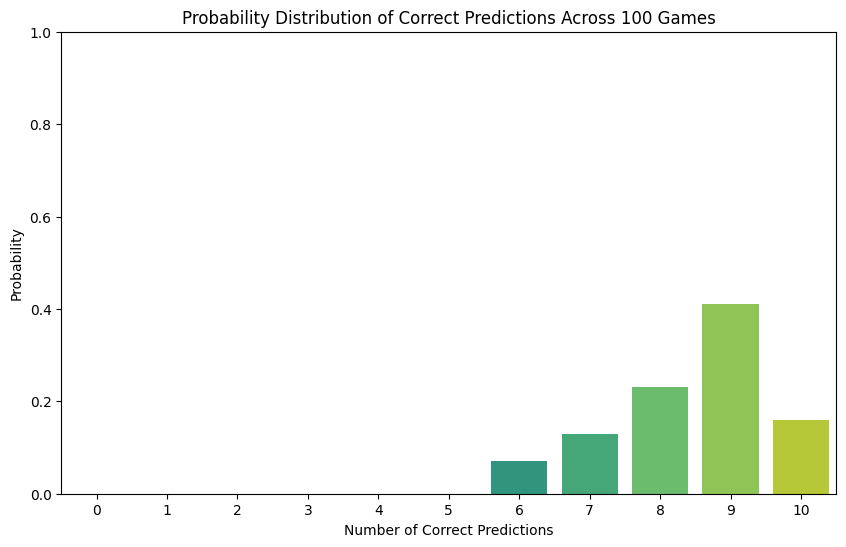

{0: 0.0,
 1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 0.0,
 5: 0.0,
 6: 0.07,
 7: 0.13,
 8: 0.23,
 9: 0.41,
 10: 0.16}

In [24]:
simulate_games(model=trained_VGG19_v4, num_runs=100, images_per_game=10)

In [21]:
# V4

# Define training parameters
number_of_fraud = 372
number_of_non_fraud = 400
epochs_training = 10
epochs_fit = 5
batch_size = 64
resolution_horizontal = resolution_horizontal
resolution_vertical = resolution_vertical
validation_split = 0.15

# Train the model using the defined function
trained_VGG19_v4 = train_model_in_batches(
    model=VGG19_custom,
    number_of_fraud=number_of_fraud,
    number_of_non_fraud=number_of_non_fraud,
    epochs_training=epochs_training,
    epochs_fit=epochs_fit,
    batch_size=batch_size,
    resolution_horizontal=resolution_horizontal,
    resolution_vertical=resolution_vertical,
    validation_split=validation_split,
    filepath_save= "models/VGG19_custom_4.keras"
)

Total Fraud Images Available: 372
Total Non-Fraud Images Available: 6091

=== Training Iteration 1/10 ===
Selected 372 Fraud images and 400 Non-Fraud images.
Data shape: (772, 200, 300, 3), Labels shape: (772, 2)
Epoch 1/5


2024-09-25 11:23:49.425383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6646 - loss: 0.6429
Epoch 1: val_accuracy improved from -inf to 0.00862, saving model to models/VGG19_custom_4.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.6685 - loss: 0.6367 - val_accuracy: 0.0086 - val_loss: 1.5257
Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8989 - loss: 0.2743
Epoch 2: val_accuracy did not improve from 0.00862
11/11 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.8988 - loss: 0.2730 - val_accuracy: 0.0000e+00 - val_loss: 3.4460
Epoch 3/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9385 - loss: 0.1725
Epoch 3: val_accuracy improved from 0.00862 to 0.04310, saving model to models/VGG19_custom_4.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.9387 - loss: 0.1718 - val_accuracy: 0.0431 - val_loss: 2.3644
Epoch 4/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9838 - loss: 0.0877
Epoch 4: val_accuracy improved from 0.04310 to 0.05172, saving model to models/VGG19_

In [22]:
keras.models.save_model(trained_VGG19_v4, "models/VGG19_custom_5.keras")

=== Evaluation Process Started ===

Retrieving test image paths...
Number of Fraud Test Images: 93
Number of Non-Fraud Test Images: 1523

Loading and preprocessing Fraud test images...
Loading and preprocessing Non-Fraud test images...

Creating labels for test data...

Combining and shuffling test data...
Total Test Samples: 1616
Data Shape: (1616, 200, 300, 3)
Labels Shape: (1616, 2)

Making predictions on test data...
51/51 ━━━━━━━━━━━━━━━━━━━━ 46s 905ms/step

Computing evaluation metrics...


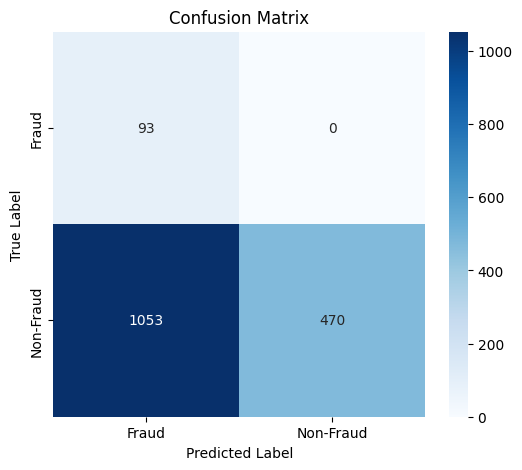


Classification Report:
              precision    recall  f1-score   support

       Fraud       0.08      1.00      0.15        93
   Non-Fraud       1.00      0.31      0.47      1523

    accuracy                           0.35      1616
   macro avg       0.54      0.65      0.31      1616
weighted avg       0.95      0.35      0.45      1616

Accuracy: 0.3484
Precision (Fraud): 0.0812
Recall (Fraud): 1.0000
F1-Score (Fraud): 0.1501

=== Evaluation Process Completed ===
Total Fraud Test Images: 93
Total Non-Fraud Test Images: 1523
Model's Expected Input Shape: (200, 300, 3)

--- Game 1/100 ---
Image 1: Incorrectly predicted as Non-Fraud. True label: Fraud.
Game 1 Score: 9/10

--- Game 2/100 ---
Image 2: Incorrectly predicted as Non-Fraud. True label: Fraud.
Image 6: Incorrectly predicted as Non-Fraud. True label: Fraud.
Image 8: Incorrectly predicted as Fraud. True label: Non-Fraud.
Image 9: Incorrectly predicted as Non-Fraud. True label: Fraud.
Game 2 Score: 6/10

--- Game 3/100 

/var/folders/wf/_h59fnv53s7476fhw5sn5smh0000gn/T/ipykernel_83002/1236226899.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=probabilities, palette="viridis")


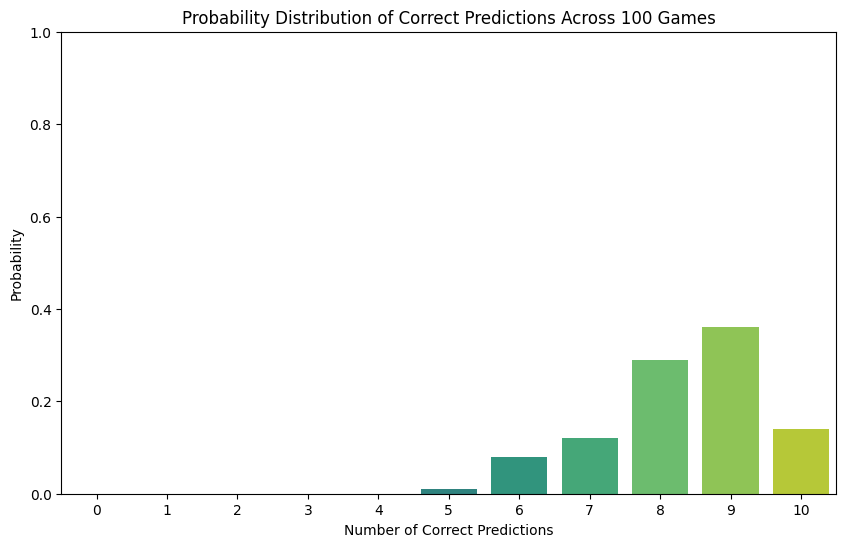

{0: 0.0,
 1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 0.0,
 5: 0.01,
 6: 0.08,
 7: 0.12,
 8: 0.29,
 9: 0.36,
 10: 0.14}

In [29]:
VGG19_custom_4 = keras.models.load_model("models/VGG19_custom_4.keras")
evaluate_model(model=VGG19_custom_4, resolution_horizontal=300, resolution_vertical=200)
simulate_games(model=VGG19_custom_4, num_runs=100, images_per_game=10)

=== Evaluation Process Started ===

Retrieving test image paths...
Number of Fraud Test Images: 93
Number of Non-Fraud Test Images: 1523

Loading and preprocessing Fraud test images...
Loading and preprocessing Non-Fraud test images...

Creating labels for test data...

Combining and shuffling test data...
Total Test Samples: 1616
Data Shape: (1616, 200, 300, 3)
Labels Shape: (1616, 2)

Making predictions on test data...
51/51 ━━━━━━━━━━━━━━━━━━━━ 43s 824ms/step

Computing evaluation metrics...


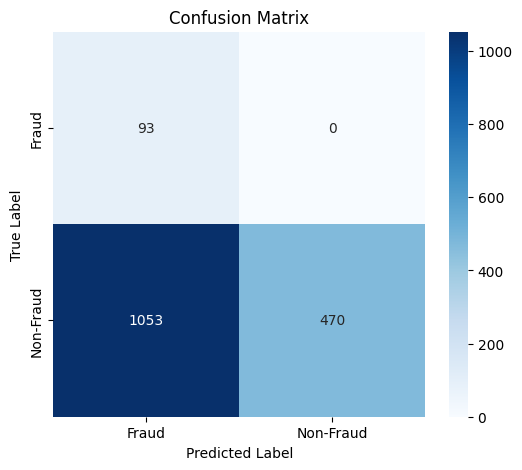


Classification Report:
              precision    recall  f1-score   support

       Fraud       0.08      1.00      0.15        93
   Non-Fraud       1.00      0.31      0.47      1523

    accuracy                           0.35      1616
   macro avg       0.54      0.65      0.31      1616
weighted avg       0.95      0.35      0.45      1616

Accuracy: 0.3484
Precision (Fraud): 0.0812
Recall (Fraud): 1.0000
F1-Score (Fraud): 0.1501

=== Evaluation Process Completed ===


{'Confusion_Matrix': array([[  93,    0],
        [1053,  470]]),
 'Classification_Report': {'Fraud': {'precision': 0.08115183246073299,
   'recall': 1.0,
   'f1-score': 0.15012106537530268,
   'support': 93.0},
  'Non-Fraud': {'precision': 1.0,
   'recall': 0.30860144451739985,
   'f1-score': 0.47165077772202707,
   'support': 1523.0},
  'accuracy': 0.34839108910891087,
  'macro avg': {'precision': 0.5405759162303665,
   'recall': 0.6543007222587,
   'f1-score': 0.3108859215486649,
   'support': 1616.0},
  'weighted avg': {'precision': 0.9471207428334456,
   'recall': 0.34839108910891087,
   'f1-score': 0.453146901949598,
   'support': 1616.0}},
 'Accuracy': 0.34839108910891087,
 'Precision_Fraud': 0.08115183246073299,
 'Recall_Fraud': 1.0,
 'F1_Score_Fraud': 0.15012106537530268}

In [23]:
evaluate_model(model=trained_VGG19_v4, resolution_horizontal=300, resolution_vertical=200)

### V2

In [11]:
# Define training parameters
number_of_fraud = 200
number_of_non_fraud = 200
epochs_training = 15
epochs_fit = 7
batch_size = 42
resolution_horizontal = resolution_horizontal
resolution_vertical = resolution_vertical
validation_split = 0.15

# Train the model using the defined function
trained_VGG19 = train_model_in_batches(
    model=VGG19_custom,
    number_of_fraud=number_of_fraud,
    number_of_non_fraud=number_of_non_fraud,
    epochs_training=epochs_training,
    epochs_fit=epochs_fit,
    batch_size=batch_size,
    resolution_horizontal=resolution_horizontal,
    resolution_vertical=resolution_vertical,
    validation_split=validation_split,
    filepath_save= "models/VGG19_custom_2.keras"
)

Total Fraud Images Available: 372
Total Non-Fraud Images Available: 6091

=== Training Iteration 1/15 ===
Selected 200 Fraud images and 200 Non-Fraud images.
Data shape: (400, 200, 300, 3), Labels shape: (400, 2)
Epoch 1/7


2024-09-24 22:17:19.844454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6493 - loss: 0.6802
Epoch 1: val_accuracy improved from -inf to 0.53333, saving model to models/VGG19_custom_2.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.6517 - loss: 0.6799 - val_accuracy: 0.5333 - val_loss: 0.6784
Epoch 2/7
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8056 - loss: 0.3784
Epoch 2: val_accuracy did not improve from 0.53333
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8048 - loss: 0.3796 - val_accuracy: 0.2000 - val_loss: 1.1536
Epoch 3/7
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8898 - loss: 0.2757
Epoch 3: val_accuracy improved from 0.53333 to 1.00000, saving model to models/VGG19_custom_2.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8908 - loss: 0.2752 - val_accuracy: 1.0000 - val_loss: 0.0171
Epoch 4/7
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9169 - loss: 0.2273
Epoch 4: val_accuracy did not improve from 1.00000
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9

In [13]:
keras.models.save_model(trained_VGG19, "models/VGG19_custom_3.keras")

2024-09-24 22:02:47.001078: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-09-24 22:02:47.001116: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-09-24 22:02:47.001124: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-09-24 22:02:47.001146: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-24 22:02:47.001165: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


=== Evaluation Process Started ===

Retrieving test image paths...
Number of Fraud Test Images: 93
Number of Non-Fraud Test Images: 1523

Loading and preprocessing Fraud test images...
Loading and preprocessing Non-Fraud test images...

Creating labels for test data...

Combining and shuffling test data...
Total Test Samples: 1616
Data Shape: (1616, 200, 300, 3)
Labels Shape: (1616, 2)

Making predictions on test data...


2024-09-24 22:03:03.345557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


51/51 ━━━━━━━━━━━━━━━━━━━━ 45s 839ms/step

Computing evaluation metrics...


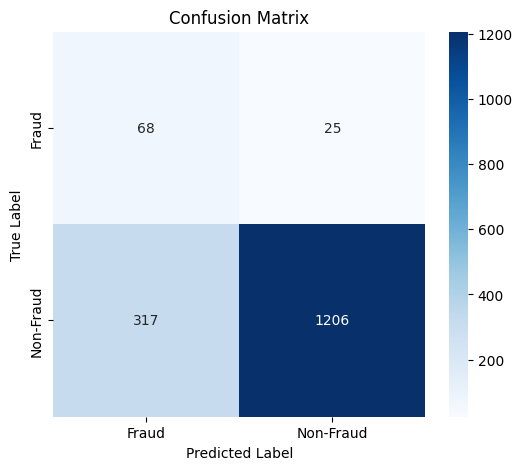


Classification Report:
              precision    recall  f1-score   support

       Fraud       0.18      0.73      0.28        93
   Non-Fraud       0.98      0.79      0.88      1523

    accuracy                           0.79      1616
   macro avg       0.58      0.76      0.58      1616
weighted avg       0.93      0.79      0.84      1616

Accuracy: 0.7884
Precision (Fraud): 0.1766
Recall (Fraud): 0.7312
F1-Score (Fraud): 0.2845

=== Evaluation Process Completed ===


{'Confusion_Matrix': array([[  68,   25],
        [ 317, 1206]]),
 'Classification_Report': {'Fraud': {'precision': 0.17662337662337663,
   'recall': 0.7311827956989247,
   'f1-score': 0.28451882845188287,
   'support': 93.0},
  'Non-Fraud': {'precision': 0.9796913078797725,
   'recall': 0.7918581746552856,
   'f1-score': 0.8758169934640523,
   'support': 1523.0},
  'accuracy': 0.7883663366336634,
  'macro avg': {'precision': 0.5781573422515746,
   'recall': 0.7615204851771051,
   'f1-score': 0.5801679109579676,
   'support': 1616.0},
  'weighted avg': {'precision': 0.9334751459943488,
   'recall': 0.7883663366336634,
   'f1-score': 0.8417880767894659,
   'support': 1616.0}},
 'Accuracy': 0.7883663366336634,
 'Precision_Fraud': 0.17662337662337663,
 'Recall_Fraud': 0.7311827956989247,
 'F1_Score_Fraud': 0.28451882845188287}

In [11]:
trained_VGG19 = keras.models.load_model("models/VGG19_custom.keras")
evaluate_model(model=trained_VGG19, resolution_horizontal=300, resolution_vertical=200)

Total Fraud Test Images: 93
Total Non-Fraud Test Images: 1523
Model's Expected Input Shape: (200, 300, 3)

--- Game 1/100 ---
Image 2: Incorrectly predicted as Non-Fraud. True label: Fraud.
Image 4: Incorrectly predicted as Non-Fraud. True label: Fraud.
Image 5: Incorrectly predicted as Non-Fraud. True label: Fraud.
Image 7: Incorrectly predicted as Non-Fraud. True label: Fraud.
Image 8: Incorrectly predicted as Non-Fraud. True label: Fraud.
Image 9: Incorrectly predicted as Non-Fraud. True label: Fraud.
Game 1 Score: 4/10

--- Game 2/100 ---
Image 3: Incorrectly predicted as Non-Fraud. True label: Fraud.
Image 4: Incorrectly predicted as Non-Fraud. True label: Fraud.
Image 7: Incorrectly predicted as Non-Fraud. True label: Fraud.
Image 8: Incorrectly predicted as Non-Fraud. True label: Fraud.
Game 2 Score: 6/10

--- Game 3/100 ---
Image 1: Incorrectly predicted as Non-Fraud. True label: Fraud.
Image 3: Incorrectly predicted as Non-Fraud. True label: Fraud.
Image 10: Incorrectly predic

/var/folders/wf/_h59fnv53s7476fhw5sn5smh0000gn/T/ipykernel_43072/1236226899.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=probabilities, palette="viridis")


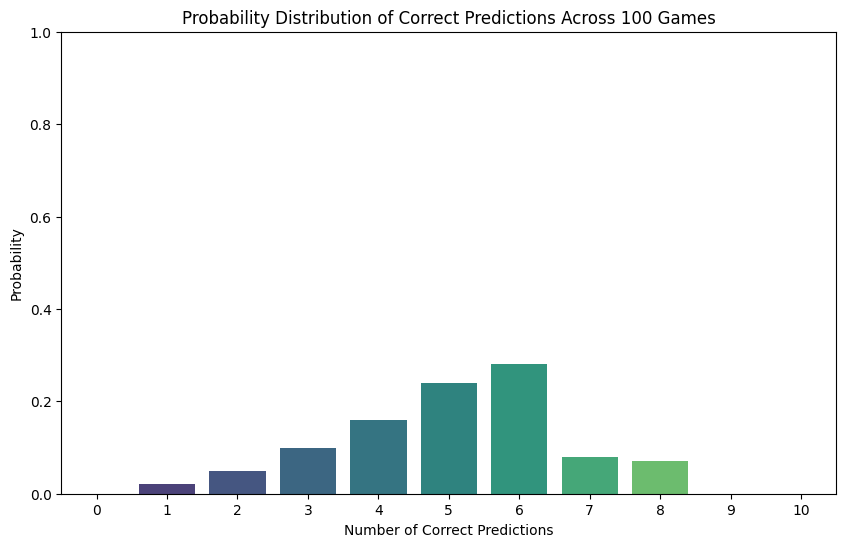

{0: 0.0,
 1: 0.02,
 2: 0.05,
 3: 0.1,
 4: 0.16,
 5: 0.24,
 6: 0.28,
 7: 0.08,
 8: 0.07,
 9: 0.0,
 10: 0.0}

In [18]:
#V2
trained_VGG19 = keras.models.load_model("models/VGG19_custom_2.keras")
simulate_games(model=trained_VGG19, num_runs=100, images_per_game=10)

Total Fraud Test Images: 93
Total Non-Fraud Test Images: 1523
Model's Expected Input Shape: (200, 300, 3)

--- Game 1/100 ---
Image 3: Incorrectly predicted as Non-Fraud. True label: Fraud.
Image 5: Incorrectly predicted as Non-Fraud. True label: Fraud.
Image 6: Incorrectly predicted as Non-Fraud. True label: Fraud.
Image 10: Incorrectly predicted as Non-Fraud. True label: Fraud.
Game 1 Score: 6/10

--- Game 2/100 ---
Image 3: Incorrectly predicted as Non-Fraud. True label: Fraud.
Image 5: Incorrectly predicted as Non-Fraud. True label: Fraud.
Image 8: Incorrectly predicted as Non-Fraud. True label: Fraud.
Image 10: Incorrectly predicted as Non-Fraud. True label: Fraud.
Game 2 Score: 6/10

--- Game 3/100 ---
Image 6: Incorrectly predicted as Non-Fraud. True label: Fraud.
Image 7: Incorrectly predicted as Non-Fraud. True label: Fraud.
Game 3 Score: 8/10

--- Game 4/100 ---
Image 4: Incorrectly predicted as Non-Fraud. True label: Fraud.
Image 5: Incorrectly predicted as Non-Fraud. True l

/var/folders/wf/_h59fnv53s7476fhw5sn5smh0000gn/T/ipykernel_43072/1236226899.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=probabilities, palette="viridis")


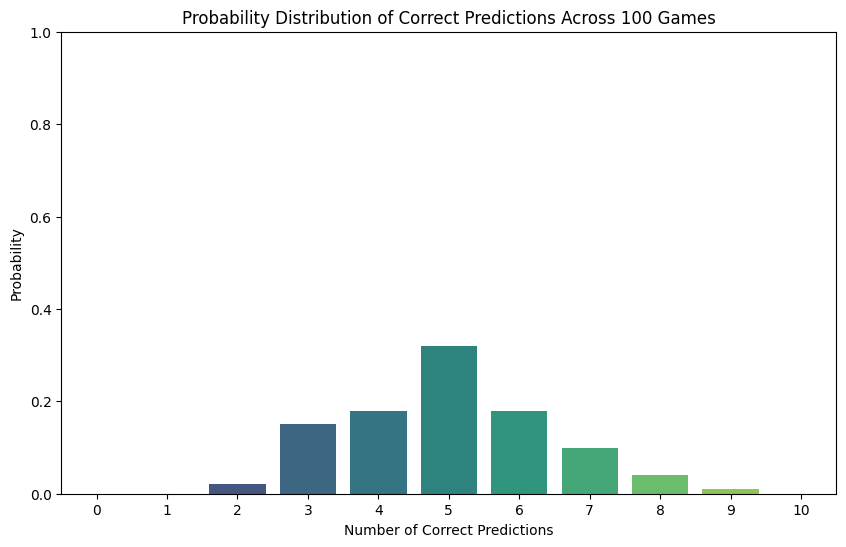

{0: 0.0,
 1: 0.0,
 2: 0.02,
 3: 0.15,
 4: 0.18,
 5: 0.32,
 6: 0.18,
 7: 0.1,
 8: 0.04,
 9: 0.01,
 10: 0.0}

In [17]:
#V3
simulate_games(model=trained_VGG19, num_runs=100, images_per_game=10)

Total Fraud Test Images: 93
Total Non-Fraud Test Images: 1523
Model's Expected Input Shape: (200, 300, 3)

--- Game 1/100 ---
Image 1: Correctly predicted as Non-Fraud.
Image 2: Incorrectly predicted as Non-Fraud. True label: Fraud.
Image 3: Incorrectly predicted as Non-Fraud. True label: Fraud.
Image 4: Correctly predicted as Non-Fraud.
Image 5: Correctly predicted as Fraud.
Image 6: Correctly predicted as Non-Fraud.
Image 7: Correctly predicted as Fraud.
Image 8: Incorrectly predicted as Non-Fraud. True label: Fraud.
Image 9: Incorrectly predicted as Non-Fraud. True label: Fraud.
Image 10: Correctly predicted as Fraud.
Game 1 Score: 6/10

--- Game 2/100 ---
Image 1: Correctly predicted as Non-Fraud.
Image 2: Correctly predicted as Non-Fraud.
Image 3: Correctly predicted as Non-Fraud.
Image 4: Correctly predicted as Non-Fraud.
Image 5: Incorrectly predicted as Fraud. True label: Non-Fraud.
Image 6: Correctly predicted as Fraud.
Image 7: Correctly predicted as Fraud.
Image 8: Incorrect

/var/folders/wf/_h59fnv53s7476fhw5sn5smh0000gn/T/ipykernel_40263/1026866769.py:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=probabilities, palette="viridis")


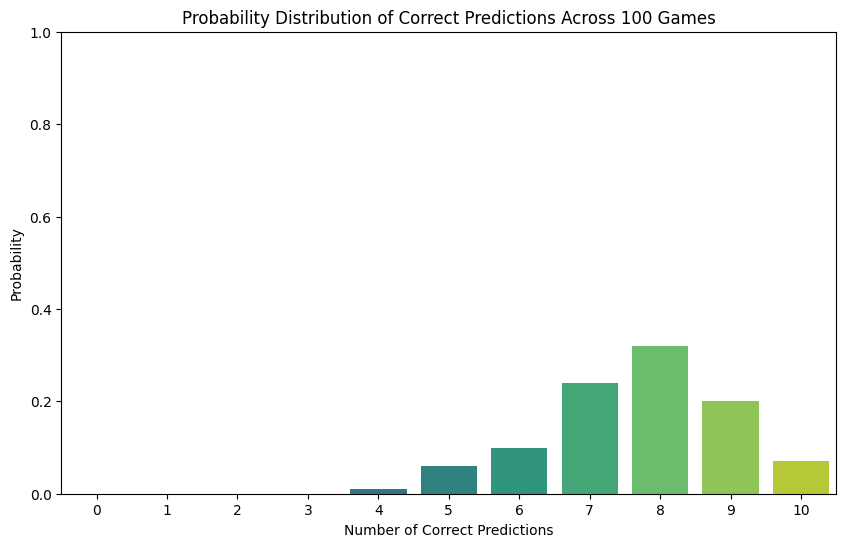

{0: 0.0,
 1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 0.01,
 5: 0.06,
 6: 0.1,
 7: 0.24,
 8: 0.32,
 9: 0.2,
 10: 0.07}

In [16]:
#V1
simulate_games(model=trained_VGG19, num_runs=100, images_per_game=10)

# OJ Code

## Data Loading & Preprocessing

In [36]:
# Parameter Data
resolution_horizontal = 300
resolution_vertical = 200
number_non_fraud_images = 300
number_fraud_images = 300 

In [34]:

import os
from PIL import Image

def load_images(filepath, resolution_horizontal, resolution_vertical, number_of_images):
  image_array = []
  image_files = os.listdir(filepath)

  for i in range(min(number_of_images, len(image_files))):
    img_path = os.path.join(filepath, image_files[i])
    img = Image.open(img_path)
    img = img.resize((resolution_horizontal, resolution_vertical), resample=Image.LANCZOS)
    img_array = np.array(img)
    image_array.append(img_array)
  return image_array


In [35]:
x_train_fraud = load_images("static/car_images/train/Fraud/", resolution_horizontal, resolution_vertical, number_of_images=number_fraud_images)
x_train_non_fraud = load_images("static/car_images/train/Non-Fraud/", resolution_horizontal, resolution_vertical, number_of_images=number_non_fraud_images)


In [10]:

# Labels are generated for the training data
# 1,0 for fraud, 0,1 for non-fraud

# Create y_fraud array with dtype int8 to save memory
y_fraud = np.zeros((len(x_train_fraud), 2), dtype=np.int8)
for i in range(len(y_fraud)):
    y_fraud[i] = [1, 0]
    y_fraud 
print(y_fraud.shape)

# Create y_non_fraud array with dtype int8 to save memory
y_non_fraud = np.zeros((len(x_train_non_fraud), 2), dtype=np.int8)
for i in range(len(y_non_fraud)):
    y_non_fraud[i] = [0, 1]
print(y_non_fraud.shape)


(300, 2)
(300, 2)


In [11]:
# Training data is concatinated
y_all = np.concatenate((y_fraud, y_non_fraud), axis=0)
x_all = np.concatenate((x_train_fraud, x_train_non_fraud), axis=0)

In [12]:
#Validatio Split is created
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_all, y_all, test_size=0.2, random_state=42)
x_all = None
y_all = None

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)


(480, 200, 300, 3)
(480, 2)
(120, 200, 300, 3)
(120, 2)


In [31]:
from sklearn.model_selection import train_test_split
def load_images_path(path, image index):
    for fraud_image in image_files_fraud:
      img_path = os.path.join("static/car_images/train/Fraud/", fraud_image)
      img = Image.open(img_path)
      img = img.resize((resolution_horizontal, resolution_vertical), resample=Image.LANCZOS)
      img_array = np.array(img)
      x_fraud.append(img_array)

    y_fraud = np.zeros((len(x_train_fraud), 2), dtype=np.int8)
    for i in range(len(y_fraud)):
      y_fraud[i] = [1, 0]
    

SyntaxError: invalid syntax (1521503889.py, line 2)

In [28]:
def y_label(fraud, data):
    if fraud == 0:
        y_non_fraud = np.zeros((len(data), 2), dtype=np.int8)
        for i in range(len(y_non_fraud)):
            y_non_fraud[i] = [0, 1]
        return y_non_fraud

    if fraud == 1:
        y_fraud = np.zeros((len(data), 2), dtype=np.int8)
        for i in range(len(y_fraud)):
            y_fraud[i] = [1, 0]
        return y_fraud

In [40]:
def Loader_Index(start, stop, filepath, resolution_horizontal, resolution_vertical):
    image_arrays = []
    image_files = os.listdir(filepath)
    image_files = image_files[start:stop]

    for image in image_files:
        img_path = os.path.join(filepath, image)
        img = Image.open(img_path)
        img = img.resize((resolution_horizontal, resolution_vertical), resample=Image.LANCZOS)
        img_array = np.array(img)
        image_arrays.append(img_array)

    return image_arrays


In [63]:
def load_images_row(model, batch_size, resolution_horizontal, resolution_vertical, n_epochs_fit, n_batches_fit):  
  image_files_fraud = os.listdir("static/car_images/train/Fraud/")
  image_files_non_fraud = os.listdir("static/car_images/train/Non-Fraud/")
  batches = len(image_files_non_fraud)//batch_size
  batches = batches-1

  current_batch = 0 

  for batch in range(batches):
    x_fraud = Loader_Index(current_batch* batch_size,  current_batch*batch_size + batch_size, "static/car_images/train/Fraud/", resolution_horizontal, resolution_vertical)
    y_fraud = y_label(1, x_fraud)

    x_non_fraud = Loader_Index(0,  len(image_files_non_fraud), "static/car_images/train/Non-Fraud/", resolution_horizontal, resolution_vertical)
    y_non_fraud = y_label(0, x_non_fraud)

    x_all = np.concatenate((x_fraud, x_non_fraud), axis=0)
    y_all = np.concatenate((y_fraud, y_non_fraud), axis=0)

    x_train, x_val, y_train, y_val = train_test_split(x_all, y_all, test_size=0.15, random_state=42)


    model.fit(
    x_train, y_train,  # Training data
    epochs= n_epochs_fit,         # Number of training epochs
    batch_size = n_batches_fit,     # Batch size
    validation_data=(x_val, y_val),
    callbacks= ModelCheckpoint('mini_model_test.keras', monitor='val_loss', save_best_only=True)
    )

    current_batch+=1
    print("Current Batch: " + str(current_batch))

  


  return(model)

    

    
  
  


In [ ]:
  # Last Iteration is saved


  x_fraud = Loader_Index(0, len(image_files_fraud), "static/car_images/train/Fraud/", resolution_horizontal, resolution_vertical)
  y_fraud = y_label(1, x_fraud)

  x_non_fraud = Loader_Index(start_batch_train, start_batch_train + batch_size, "static/car_images/train/Non-Fraud/", resolution_horizontal, resolution_vertical)
  y_non_fraud = y_label(0, x_non_fraud)

  x_all = np.concatenate((x_fraud, x_non_fraud), axis=0)
  y_all = np.concatenate((y_fraud, y_non_fraud), axis=0)

  x_train, x_val, y_train, y_val = train_test_split(x_all, y_all, test_size=0.2, random_state=42)


  model.fit(
    x_train, y_train,  # Training data
    epochs= n_epochs_fit,         # Number of training epochs
    batch_size = n_batches_fit,     # Batch size
    validation_data=(x_val, y_val),
    callbacks= ModelCheckpoint('batch_trained.keras', monitor='val_loss', save_best_only=True)
    )

In [ ]:
  # Last Iteration is saved

  x_fraud = Loader_Index(0, len(image_files_fraud), "static/car_images/train/Fraud/", resolution_horizontal, resolution_vertical)
  y_fraud = y_label(1, x_fraud)

  x_non_fraud = Loader_Index(start_batch_train, start_batch_train + batch_size, "static/car_images/train/Non-Fraud/", resolution_horizontal, resolution_vertical)
  y_non_fraud = y_label(0, x_non_fraud)

  x_all = np.concatenate((x_fraud, x_non_fraud), axis=0)
  y_all = np.concatenate((y_fraud, y_non_fraud), axis=0)

  x_train, x_val, y_train, y_val = train_test_split(x_all, y_all, test_size=0.2, random_state=42)


  model.fit(
    x_train, y_train,  # Training data
    epochs= n_epochs_fit,         # Number of training epochs
    batch_size = n_batches_fit,     # Batch size
    validation_data=(x_val, y_val),
    callbacks= ModelCheckpoint('/models/batch_trained.keras', monitor='val_loss', save_best_only=True)
    )

In [53]:
def saving(model, path):
    model.save(path)
    print("Model saving in path: ", path)



In [56]:
saving(own_model_mini, 'mini_model_test.keras')

Model saving in path:  mini_model_test.keras


In [64]:
load_images_row(own_model_mini, 300, 300, 200, n_batches_fit = 64,n_epochs_fit= 5 )

Epoch 1/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 24s 258ms/step - accuracy: 0.9865 - loss: 0.0796 - val_accuracy: 0.9948 - val_loss: 0.0234
Epoch 2/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 19s 228ms/step - accuracy: 0.9951 - loss: 0.0171 - val_accuracy: 0.9875 - val_loss: 0.0277
Epoch 3/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 19s 225ms/step - accuracy: 0.9967 - loss: 0.0088 - val_accuracy: 0.9948 - val_loss: 0.0153
Epoch 4/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 232ms/step - accuracy: 0.9980 - loss: 0.0060 - val_accuracy: 0.9979 - val_loss: 0.0038
Epoch 5/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 18s 214ms/step - accuracy: 0.9999 - loss: 9.7830e-04 - val_accuracy: 0.9990 - val_loss: 0.0027
Current Batch: 1
Epoch 1/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 248ms/step - accuracy: 0.9973 - loss: 0.0105 - val_accuracy: 0.9989 - val_loss: 0.0024
Epoch 2/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 18s 216ms/step - accuracy: 0.9991 - loss: 0.0013 - val_accuracy: 0.9978 - val_loss: 0.0072
Epoch 3/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 17s 211ms/step - accuracy: 0.9989 - loss: 0.00

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 4 dimension(s)

In [ ]:
def 

In [ ]:

# Create y_fraud array with dtype int8 to save memory
def labeller(x,fraud,)
    if fraud == 1:
        y_fraud = np.zeros((len(x_train_fraud), 2), dtype=np.int8)
        for i in range(len(y_fraud)):
            y_fraud[i] = [1, 0]
        
        
    print(y_fraud.shape)

# Create y_non_fraud array with dtype int8 to save memory
y_non_fraud = np.zeros((len(x_train_non_fraud), 2), dtype=np.int8)
for i in range(len(y_non_fraud)):
    y_non_fraud[i] = [0, 1]
print(y_non_fraud.shape)

## Model Training

In [9]:
# Early stopping to stop training when the validation loss doesn't improve for 10 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Reduce learning rate when the validation loss doesn't improve for 5 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-4)

# Save the best model based on validation loss
model_checkpoint = ModelCheckpoint('/models/best_model_today.keras', monitor='val_loss', save_best_only=True)


In [10]:
def majority_choice():
    if number_fraud_images > number_non_fraud_images:
        return("Majority Choice would lead an accuracy of "+str(number_fraud_images/number_non_fraud_images) + "%")
    if number_fraud_images < number_non_fraud_images:
        return("Majority Choice would lead an accuracy of "+str(number_non_fraud_images/number_fraud_images) + "%")
    if number_fraud_images == number_non_fraud_images:
         return("Majority Choice would lead an accuracy of 50% ")
    
majority_choice()

'Majority Choice would lead an accuracy of 50% '

## Medium

In [11]:
OwnModel_Medium = Sequential(name='Own_Medium',  # Naming the entire model
    layers=[
        layers.Input(shape=(resolution_vertical, resolution_horizontal, 3), name='input_medium'),

        layers.Conv2D(128, (3, 3), activation='relu', name='conv2d_128_medium'),
        layers.MaxPooling2D((2, 2), name='maxpool2d_1_medium'),

        layers.Conv2D(64, (3, 3), activation='relu', name='conv2d_64_medium_1'),
        layers.MaxPooling2D((2, 2), name='maxpool2d_2_medium'),

        layers.Conv2D(64, (3, 3), activation='relu', name='conv2d_64_medium_2'),
        
        layers.Dense(32, activation='relu', name='dense_32_medium'),
        layers.MaxPooling2D((2, 2), name='maxpool2d_3_medium'),
        layers.Dropout(0.2, name='dropout_medium'),
        layers.Flatten(name='flatten_medium'),
        layers.Dense(2, activation='softmax', name='dense_2_medium')
    ]
)

# Compile the model
OwnModel_Medium.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
OwnModel_Medium.summary()

2024-08-13 22:22:10.953066: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-08-13 22:22:10.953102: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-08-13 22:22:10.953107: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-08-13 22:22:10.953272: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-13 22:22:10.953291: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "Own_Medium"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_128_medium (Conv2D)      │ (None, 198, 298, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_1_medium              │ (None, 99, 149, 128)   │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64_medium_1 (Conv2D)     │ (None, 97, 147, 64)    │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_2_medium              │ (None, 48, 73, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64_medium_2 (Conv2D)     │ (None, 46, 71, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32_medium (Dense)         │ (None, 46, 71, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_3_medium              │ (None, 23, 35, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_medium (Dropout)        │ (None, 23, 35, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_medium (Flatten)        │ (None, 25760)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2_medium (Dense)          │ (None, 2)              │        51,522 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,906 (655.88 KB)

 Trainable params: 167,906 (655.88 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
OwnModel_Medium.compile(optimizer="Adam",
              loss='binary_crossentropy',
              metrics=['F1Score'])

In [13]:
model_checkpoint_own = ModelCheckpoint('Models/own_model_Medium.keras', monitor='val_loss', save_best_only=True)

OwnModel = OwnModel_Medium.fit(
    x_train, y_train,  # Training data
    epochs=5,         # Number of training epochs
    batch_size=64,     # Batch size
    validation_data=(x_val, y_val),    
    callbacks=[model_checkpoint_own]
)

Epoch 1/5


2024-08-13 22:22:16.160022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - F1Score: 0.5073 - loss: 12.8235 - val_F1Score: 0.4245 - val_loss: 0.9238
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - F1Score: 0.4778 - loss: 1.2735 - val_F1Score: 0.4192 - val_loss: 0.8112
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - F1Score: 0.5432 - loss: 0.7827 - val_F1Score: 0.5910 - val_loss: 0.7095
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 36s 5s/step - F1Score: 0.6373 - loss: 0.6672 - val_F1Score: 0.5226 - val_loss: 0.6995
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - F1Score: 0.6410 - loss: 0.6423 - val_F1Score: 0.5593 - val_loss: 0.6767


## Mini

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the lighter model with custom names
def create_mini_model(input_shape=(300, 200, 3)):
    model = Sequential(name="own_model_mini")

    # First convolutional layer
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape, name="conv_mini_1"))
    model.add(MaxPooling2D(pool_size=(2, 2), name="maxpool_mini_1"))

    # Second convolutional layer
    model.add(Conv2D(32, (3, 3), activation='relu', name="conv_mini_2"))
    model.add(MaxPooling2D(pool_size=(2, 2), name="maxpool_mini_2"))


    # Fully connected layer
    model.add(Dense(32, activation='relu', name="dense_mini_1"))
    model.add(Dropout(0.3, name="dropout_mini_1"))  # Reduced dropout rate for regularization
    # Flatten the feature maps to feed into the dense layer
    model.add(Flatten(name="flatten_mini"))

    # Output layer for binary classification (one-hot encoded)
    model.add(Dense(2, activation='softmax', name="output_mini"))

    # Compile the model
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    return model

# Create the mini model
own_model_mini = create_mini_model()

# Display the model's architecture
own_model_mini.summary()

/Users/lucasmuller/Desktop/Githubg/Model_Creation/Beat-the-Model-Cration/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "own_model_mini"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_mini_1 (Conv2D)            │ (None, 298, 198, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_mini_1 (MaxPooling2D)   │ (None, 149, 99, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_mini_2 (Conv2D)            │ (None, 147, 97, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_mini_2 (MaxPooling2D)   │ (None, 73, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_mini_1 (Dense)            │ (None, 73, 48, 32)     │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_mini_1 (Dropout)        │ (None, 73, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_mini (Flatten)          │ (None, 112128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_mini (Dense)             │ (None, 2)              │       224,258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 230,402 (900.01 KB)

 Trainable params: 230,402 (900.01 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
model_checkpoint_own_mini = ModelCheckpoint('Models/own_model_mini.keras', monitor='val_loss', save_best_only=True)

OwnModel = own_model_mini.fit(
    x_train, y_train,  # Training data
    epochs=30,         # Number of training epochs
    batch_size=64,     # Batch size
    validation_data=(x_val, y_val),    
    callbacks=[model_checkpoint_own_mini]
)

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9000 - val_loss: 2.0606
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step - accuracy: 1.0000 - loss: 6.7198e-04 - val_accuracy: 0.8917 - val_loss: 2.1142
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - accuracy: 1.0000 - loss: 1.0459e-04 - val_accuracy: 0.8917 - val_loss: 2.1381
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step - accuracy: 1.0000 - loss: 3.1125e-04 - val_accuracy: 0.8917 - val_loss: 2.1410
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - accuracy: 1.0000 - loss: 6.1854e-05 - val_accuracy: 0.8917 - val_loss: 2.1413
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - accuracy: 0.9993 - loss: 0.0015 - val_accuracy: 0.8833 - val_loss: 2.2339
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step - accuracy: 1.0000 - loss: 8.0024e-05 - val_accuracy: 0.8833 - val_loss: 2.4657
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - accuracy: 1.0000 - loss: 3.5768e-05 - val_accu

## Small

In [30]:
OwnModel_Small = Sequential(name='own_small',  # Naming the entire model
    layers=[
        layers.Input(shape=(resolution_vertical, resolution_horizontal, 3), name='input_small'),

        layers.Conv2D(64, (3, 3), activation='relu', name='conv2d_64_small'),
        layers.MaxPooling2D((2, 2), name='maxpool2d_1_small'),

        layers.Conv2D(32, (3, 3), activation='relu', name='conv2d_32_small_1'),
        layers.Conv2D(32, (3, 3), activation='relu', name='conv2d_32_small_2'),
        layers.MaxPooling2D((2, 2), name='maxpool2d_2_small'),

        layers.Conv2D(32, (3, 3), activation='relu', name='conv2d_32_small_3'),
        layers.Flatten(name='flatten_small'),
        layers.Dense(2, activation='softmax', name='dense_2_small')
    ]
)

# Compile the model
OwnModel_Small.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['F1Score'])

# Model summary
OwnModel_Small.summary()

Model: "own_small"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_64_small (Conv2D)        │ (None, 198, 298, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_1_small               │ (None, 99, 149, 64)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32_small_1 (Conv2D)      │ (None, 97, 147, 32)    │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32_small_2 (Conv2D)      │ (None, 95, 145, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_2_small               │ (None, 47, 72, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32_small_3 (Conv2D)      │ (None, 45, 70, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_small (Flatten)         │ (None, 100800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2_small (Dense)           │ (None, 2)              │       201,602 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240,354 (938.88 KB)

 Trainable params: 240,354 (938.88 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
model_checkpoint_own_small = ModelCheckpoint('Models/own_model_small.keras', monitor='val_loss', save_best_only=True)

OwnModel = OwnModel_Small.fit(
    x_train, y_train,  # Training data
    epochs=10,         # Number of training epochs
    batch_size=64,     # Batch size
    validation_data=(x_val, y_val),    
    callbacks=[model_checkpoint_own_small]
)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 745ms/step - F1Score: 0.4801 - loss: 41.8008 - val_F1Score: 0.3844 - val_loss: 8.7287
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 657ms/step - F1Score: 0.4574 - loss: 5.3917 - val_F1Score: 0.4302 - val_loss: 1.0453
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 641ms/step - F1Score: 0.5494 - loss: 0.8622 - val_F1Score: 0.4994 - val_loss: 0.6803
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 635ms/step - F1Score: 0.7664 - loss: 0.5254 - val_F1Score: 0.6154 - val_loss: 0.6638
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 640ms/step - F1Score: 0.8989 - loss: 0.4183 - val_F1Score: 0.6621 - val_loss: 0.5981
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 640ms/step - F1Score: 0.9325 - loss: 0.2731 - val_F1Score: 0.6819 - val_loss: 0.5902
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 633ms/step - F1Score: 0.9609 - loss: 0.1742 - val_F1Score: 0.7250 - val_loss: 0.5723
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 632ms/step - F1Score: 0.9904 - loss: 0.0967 - val_F1Score: 0.7408 - val_loss: 0.6378
Epoch 9

## Large

In [35]:
OwnModel_Large = Sequential([
    layers.Input(shape=(resolution_vertical, resolution_horizontal, 3)),
    layers.Conv2D(256, (3, 3), activation='relu',padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu',padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Flatten(),
    layers.Dense(2, activation='softmax')
])
OwnModel_Large.summary()
OwnModel_Large.compile(optimizer="Adam",
              loss='binary_crossentropy',
              metrics=['F1Score'])

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_76 (Conv2D)              │ (None, 200, 300, 256)  │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_76 (MaxPooling2D) │ (None, 100, 150, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 100, 150, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_77 (MaxPooling2D) │ (None, 50, 75, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_78 (Conv2D)              │ (None, 50, 75, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_78 (MaxPooling2D) │ (None, 25, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ (None, 25, 37, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_80 (Conv2D)              │ (None, 25, 37, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_79 (MaxPooling2D) │ (None, 12, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_81 (Conv2D)              │ (None, 12, 18, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 13824)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 2)              │        27,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,067,586 (4.07 MB)

 Trainable params: 1,067,586 (4.07 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
model_checkpoint_own_large = ModelCheckpoint('Models/own_model_large.keras', monitor='val_f1_score', save_best_only=True)

OwnModel = OwnModel_Large.fit(
    x_train, y_train,  # Training data
    epochs=5,         # Number of training epochs
    batch_size=64,     # Batch size
    validation_data=(x_val, y_val),    
    callbacks=[model_checkpoint_own_large]
)

Epoch 1/5
1/8 ━━━━━━━━━━━━━━━━━━━━ 4:35 39s/step - F1Score: 0.3118 - loss: 8.4616

## GPT

In [43]:
# GPT 

import tensorflow as tf
from tensorflow.keras import layers, Sequential

# Define resolution


# Define the model with named layers
model_gpt = Sequential([
    layers.Input(shape=(resolution_vertical, resolution_horizontal, 3), name='input_gpt'),

    # Convolutional layers with fewer filters
    layers.Conv2D(16, (3, 3), activation='relu', padding='same', name='conv2d_16_gpt'),
    layers.MaxPooling2D((2, 2), name='maxpool2d_1_gpt'),

    layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv2d_32_gpt'),
    layers.MaxPooling2D((2, 2), name='maxpool2d_2_gpt'),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2d_64_gpt'),
    layers.MaxPooling2D((2, 2), name='maxpool2d_3_gpt'),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2d_64_2_gpt'),
    layers.MaxPooling2D((2, 2), name='maxpool2d_4_gpt'),

    # Flatten and dense layers
    layers.Flatten(name='flatten_gpt'),
    layers.Dropout(0.5, name='dropout_gpt'),  # Dropout for regularization
    layers.Dense(128, activation='relu', name='dense_128_gpt'),
    layers.Dense(2, activation='softmax', name='output_dense_gpt')
])

# Compile the model
model_gpt.compile(optimizer='adam', loss='binary_crossentropy', metrics=['F1Score'])

# Model summary
model_gpt.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16_gpt (Conv2D)          │ (None, 200, 300, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_1_gpt (MaxPooling2D)  │ (None, 100, 150, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32_gpt (Conv2D)          │ (None, 100, 150, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_2_gpt (MaxPooling2D)  │ (None, 50, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64_gpt (Conv2D)          │ (None, 50, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_3_gpt (MaxPooling2D)  │ (None, 25, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64_2_gpt (Conv2D)        │ (None, 25, 37, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_4_gpt (MaxPooling2D)  │ (None, 12, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_gpt (Flatten)           │ (None, 13824)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_gpt (Dropout)           │ (None, 13824)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128_gpt (Dense)           │ (None, 128)            │     1,769,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_gpt (Dense)        │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,830,370 (6.98 MB)

 Trainable params: 1,830,370 (6.98 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
model_checkpoint_gpt= ModelCheckpoint('Models/gpt.keras', monitor='val_loss', save_best_only=True)

OwnModel = model_gpt.fit(
    x_train, y_train,  # Training data
    epochs=5,         # Number of training epochs
    batch_size=64,     # Batch size
    validation_data=(x_val, y_val),    
    callbacks=[model_checkpoint_gpt]
)

Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 341ms/step - F1Score: 0.4520 - loss: 45.3467 - val_F1Score: 0.4562 - val_loss: 0.8205
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step - F1Score: 0.5095 - loss: 0.8315 - val_F1Score: 0.4049 - val_loss: 0.6870
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - F1Score: 0.5699 - loss: 0.6845 - val_F1Score: 0.5731 - val_loss: 0.6763
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - F1Score: 0.5871 - loss: 0.6635 - val_F1Score: 0.4920 - val_loss: 0.6557
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - F1Score: 0.6392 - loss: 0.6207 - val_F1Score: 0.6748 - val_loss: 0.6332


In [20]:
OwnModel = model_gpt.fit(
    x_train, y_train,  # Training data
    epochs=5,         # Number of training epochs
    batch_size=64,     # Batch size
    validation_data=(x_val, y_val),    
    callbacks=[model_checkpoint_gpt]
)

Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step - F1Score: 0.3348 - loss: 0.6931 - val_F1Score: 0.3258 - val_loss: 0.6932
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - F1Score: 0.3484 - loss: 0.6931 - val_F1Score: 0.3258 - val_loss: 0.6932
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - F1Score: 0.3410 - loss: 0.6931 - val_F1Score: 0.3258 - val_loss: 0.6932
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - F1Score: 0.3305 - loss: 0.6933 - val_F1Score: 0.3258 - val_loss: 0.6932
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step - F1Score: 0.3407 - loss: 0.6931 - val_F1Score: 0.3258 - val_loss: 0.6932


## Meta Machine Learning

In [57]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, Model

# Load pre-trained base models
base_model1 = load_model('Models/gpt.keras', compile=False )
base_model2 = load_model('Models/own_model_Medium.keras', compile=False)
base_model3 = load_model('Models/own_model_small.keras', compile=False)

# Freeze the base models
base_model1.trainable = False
base_model2.trainable = False
base_model3.trainable = False



# Define input shape
input_shape = (resolution_vertical, resolution_horizontal, 3)  # Adjust this if necessary to match the input shape of your models


# Define the input layer
input_layer = layers.Input(shape=input_shape)

# Get outputs from each base model
output1 = base_model1(input_layer)
output2 = base_model2(input_layer)
output3 = base_model3(input_layer)


# Concatenate outputs from base models
concatenated = layers.concatenate([output1, output2, output3], axis=-1)

# Add a classification head
x = layers.Flatten()(concatenated)
x = layers.Dense(128, activation='relu')(x)  # You can adjust the number of units here
x = layers.Dropout(0.5)(x)
output = layers.Dense(2, activation='softmax')(x)  # For binary classification with one-hot encoding

# Create the stacked model
mml = Model(inputs=input_layer, outputs=output)

# Compile the stacked model
mml.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the stacked model
mml.summary()

Model: "functional_254"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 200, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 2)         │  1,830,370 │ input_layer_11[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Own_Medium          │ (None, 2)         │    167,906 │ input_layer_11[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ own_small           │ (None, 2)         │    240,354 │ input_layer_11[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 6)         │          0 │ sequential_3[0][… │
│ (Concatenate)       │                   │            │ Own_Medium[0][0], │
│                     │                   │            │ own_small[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 6)         │          0 │ concatenate_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 128)       │        896 │ flatten_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 128)       │          0 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 2)         │        258 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,239,784 (8.54 MB)

 Trainable params: 1,154 (4.51 KB)

 Non-trainable params: 2,238,630 (8.54 MB)

In [58]:
model_checkpoint_mml= ModelCheckpoint('Models/mml_own.keras', monitor='val_loss', save_best_only=True)

OwnModel = mml.fit(
    x_train, y_train,  # Training data
    epochs=5,         # Number of training epochs
    batch_size=64,     # Batch size
    validation_data=(x_val, y_val),    
    callbacks=[model_checkpoint_mml]
)

Epoch 1/5


# Transfer Learning

## VGG19 

In [11]:
# Initially I tried to freeze the layer fron the model above but my approach didnt seem to work. I didnt understand why. 
# After spending some time on that, I opted for a different approach namely reading the documentation on the Keras Website 
import os
import certifi


# Set SSL certificate file path
os.environ['SSL_CERT_FILE'] = certifi.where()

from keras.applications import VGG19

# Load InceptionV3 model without the top layer and freeze its layers
base_model_custom = VGG19(weights="imagenet", include_top=False, input_shape=(resolution_vertical, resolution_horizontal, 3))
base_model_custom.trainable = False



# Build the custom top layers
x = base_model_custom.output
x = layers.Conv2D(256, activation="relu", kernel_size=(2, 2), padding="VALID", name="VGG19_Conv2D_1")(x)
x = layers.BatchNormalization(name="VGG19_BatchNormalization_1")(x)
x = layers.Dropout(0.2, seed=42, name="VGG19_Dropout_1")(x)
x = layers.Conv2D(128, activation="relu", kernel_size=(2, 2), padding="VALID", name="VGG19_Conv2D_2")(x)
x = layers.BatchNormalization(name="VGG19_BatchNormalization_2")(x)
x = layers.Conv2D(128, activation="relu", kernel_size=(2, 2), padding="VALID", name="VGG19_Conv2D_3")(x)
x = layers.BatchNormalization(name="VGG19_BatchNormalization_3")(x)
x = layers.GlobalAveragePooling2D(name="VGG19_GlobalAveragePooling2D")(x)
x = layers.Dropout(0.2, seed=42, name="VGG19_Dropout_2")(x)
x = layers.Flatten(name="VGG19_Flatten")(x)
predictions = layers.Dense(2, activation="sigmoid", name="VGG19_Dense")(x)

# Combine the base model with the custom top layers
VGG19_custom = Model(inputs=base_model_custom.input, outputs=predictions, name="VGG19_Model")

VGG19_custom.compile(optimizer=keras.optimizers.Adam(),
                     loss='binary_crossentropy',
                     metrics=[F1Score()])

VGG19_custom.summary()






2024-08-19 17:19:11.863858: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-08-19 17:19:11.864386: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-08-19 17:19:11.864397: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-08-19 17:19:11.865129: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-19 17:19:11.865541: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "VGG19_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 200, 300, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 200, 300, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 100, 150, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 100, 150, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 100, 150, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 50, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 50, 75, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 50, 75, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 50, 75, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 50, 75, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 25, 37, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 25, 37, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 25, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 25, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 25, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 12, 18, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 12, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 12, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 12, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 12, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 6, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ VGG19_Conv2D_1 (Conv2D)         │ (None, 5, 8, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ VGG19_BatchNormalization_1      │ (None, 5, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,748,098 (79.15 MB)

 Trainable params: 722,690 (2.76 MB)

 Non-trainable params: 20,025,408 (76.39 MB)

In [13]:
model_checkpoint_mml_vgg19 = ModelCheckpoint(filepath='./models/MML_VGG_19.keras', monitor='val_loss', save_best_only=True)
history = VGG19_custom.fit(
    x_train, y_train,  # Training data
    epochs=5,                 # Increase number of epochs
    batch_size=50,             # Adjusted batch size for better performance
    validation_data=(x_val, y_val),    
    callbacks=[model_checkpoint_mml_vgg19]
)

Epoch 1/5


2024-08-19 17:21:10.510314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - f1_score: 0.6733 - loss: 0.6043 - val_f1_score: 0.8493 - val_loss: 0.3575
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - f1_score: 0.9392 - loss: 0.1772 - val_f1_score: 0.8229 - val_loss: 0.4859
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - f1_score: 0.9790 - loss: 0.0792 - val_f1_score: 0.8986 - val_loss: 0.2562
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - f1_score: 0.9862 - loss: 0.0624 - val_f1_score: 0.9244 - val_loss: 0.2130
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - f1_score: 0.9936 - loss: 0.0237 - val_f1_score: 0.8743 - val_loss: 0.3371


## Inception 

In [14]:
from keras.applications.inception_v3 import InceptionV3

# Load InceptionV3 model without the top layer and freeze its layers
base_model_custom = InceptionV3(weights="imagenet", include_top=False, input_shape=(resolution_vertical, resolution_horizontal, 3))
base_model_custom.trainable = False

# Build the custom top layers
x = base_model_custom.output
x = layers.Conv2D(256, activation="relu", kernel_size=(2, 2), padding="VALID", name="Inception_V3_Conv2D_1")(x)
x = layers.BatchNormalization(name="Inception_V3_BatchNormalization_1")(x)
x = layers.Dropout(0.2, seed=42, name="Inception_V3_Dropout_1")(x)
x = layers.Conv2D(128, activation="relu", kernel_size=(2, 2), padding="VALID", name="Inception_V3_Conv2D_2")(x)
x = layers.BatchNormalization(name="Inception_V3_BatchNormalization_2")(x)
x = layers.Conv2D(128, activation="relu", kernel_size=(2, 2), padding="VALID", name="Inception_V3_Conv2D_3")(x)
x = layers.BatchNormalization(name="Inception_V3_BatchNormalization_3")(x)
x = layers.GlobalAveragePooling2D(name="Inception_V3_GlobalAveragePooling2D")(x)
x = layers.Dropout(0.2, seed=42, name="Inception_V3_Dropout_2")(x)
x = layers.Flatten(name="Inception_V3_Flatten")(x)
predictions = layers.Dense(2, activation="sigmoid", name="Inception_V3_Dense")(x)

# Combine the base model with the custom top layers
InceptionV3_custom = Model(inputs=base_model_custom.input, outputs=predictions, name="Inception_V3_Model")

InceptionV3_custom.compile(optimizer=keras.optimizers.Adam(),
                           loss='binary_crossentropy',
                           metrics=[F1Score()])

InceptionV3_custom.summary()

Model: "Inception_V3_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 200, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 99, 149,   │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 99, 149,   │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 99, 149,   │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 97, 147,   │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 97, 147,   │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 97, 147,   │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 97, 147,   │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 97, 147,   │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 97, 147,   │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 48, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 48, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 48, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 46, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 46, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 46, 71,    │          0 │ batch_normalizat

 Total params: 24,099,362 (91.93 MB)

 Trainable params: 2,295,554 (8.76 MB)

 Non-trainable params: 21,803,808 (83.17 MB)

In [17]:
# Save the best model based on validation loss

model_checkpoint_mml_inception = ModelCheckpoint(filepath='./models/MML_Inception.keras', monitor='val_loss', save_best_only=True)
history = InceptionV3_custom.fit(
    x_train, y_train,  # Training data
    epochs=20,                 # Increase number of epochs
    batch_size=100,             # Adjusted batch size for better performance
    validation_data=(x_val, y_val),    
    callbacks=[early_stopping, model_checkpoint_mml_inception]
)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - f1_score: 0.9993 - loss: 0.0378 - val_f1_score: 0.6622 - val_loss: 0.7403
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - f1_score: 0.9975 - loss: 0.0414 - val_f1_score: 0.7248 - val_loss: 0.5685
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - f1_score: 0.9983 - loss: 0.0321 - val_f1_score: 0.7321 - val_loss: 0.6436
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - f1_score: 0.9976 - loss: 0.0254 - val_f1_score: 0.7416 - val_loss: 0.5910
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - f1_score: 0.9940 - loss: 0.0294 - val_f1_score: 0.7545 - val_loss: 0.6315
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - f1_score: 0.9960 - loss: 0.0303 - val_f1_score: 0.7545 - val_loss: 0.7482
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - f1_score: 0.9935 - loss: 0.0260 - val_f1_score: 0.7163 - val_loss: 0.7528
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - f1_score: 0.9978 - loss: 0.0265 - val_f1_score: 0.6591 - val_loss: 0.9795
Epoch 9/20
5/5 

# Test

In [19]:
def get_all_image_paths(directory):
    """
    Retrieves all image file paths from the specified directory.
    
    Parameters:
        directory (str): Path to the directory containing images.
        
    Returns:
        list: List of image file paths.
    """
    image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')  # Supported image formats
    all_images = [os.path.join(directory, img) for img in os.listdir(directory)
                 if os.path.isfile(os.path.join(directory, img)) and img.lower().endswith(image_extensions)]
    return all_images


In [20]:
import numpy as np

def create_labels(num_fraud, num_non_fraud):
    """
    Creates one-hot encoded labels for Fraud and Non-Fraud images.
    
    Parameters:
        num_fraud (int): Number of Fraud images.
        num_non_fraud (int): Number of Non-Fraud images.
    
    Returns:
        np.array: Array of one-hot encoded labels ([1, 0] for Fraud, [0, 1] for Non-Fraud).
    """
    # Fraud label: [1, 0]
    fraud_labels = np.tile([1, 0], (num_fraud, 1))
    # Non-Fraud label: [0, 1]
    non_fraud_labels = np.tile([0, 1], (num_non_fraud, 1))
    # Combine labels
    return np.concatenate((fraud_labels, non_fraud_labels), axis=0)


In [21]:
from sklearn.utils import class_weight
import numpy as np

def calculate_class_weights(labels):
    """
    Calculates class weights to handle class imbalance.
    
    Parameters:
        labels (np.array): Array of integer labels.
    
    Returns:
        dict: Dictionary mapping class indices to weights.
    """
    class_weights_array = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(labels),
        y=labels
    )
    return {i : weight for i, weight in enumerate(class_weights_array)}


In [22]:
import numpy as np
import os
import random
from keras.utils import to_categorical
from sklearn.utils import class_weight
import gc
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping

def train_model_in_batches(model, number_of_fraud, number_of_non_fraud, epochs_training, 
                          epochs_fit, batch_size, resolution_horizontal, resolution_vertical, 
                          validation_split, filepath_save):
    """
    Trains the given model using batches of Fraud and Non-Fraud images to manage memory usage.
    Incorporates class weights to handle class imbalance.
    Saves the best performing model of each iteration based on Validation Accuracy by overwriting
    the previously saved model.
    
    Parameters:
        model (keras.Model): The neural network model to train.
        number_of_fraud (int): Number of Fraud images to load per training iteration.
        number_of_non_fraud (int): Number of Non-Fraud images to load per training iteration.
        epochs_training (int): Number of training iterations.
        epochs_fit (int): Number of epochs per model.fit call.
        batch_size (int): Batch size for training.
        resolution_horizontal (int): Width to resize images.
        resolution_vertical (int): Height to resize images.
        validation_split (float): Fraction of data to use for validation.
        filepath_save (str): Filepath to save the best model.
        
    Returns:
        keras.Model: The trained model with the best validation performance.
    """
    # Define directories
    fraud_dir = "car_images/train/Fraud"
    non_fraud_dir = "car_images/train/Non-Fraud"
    
    # Get all image paths once to avoid repeated disk access
    fraud_image_paths_all = get_all_image_paths(fraud_dir)
    non_fraud_image_paths_all = get_all_image_paths(non_fraud_dir)
    total_fraud_images = len(fraud_image_paths_all)
    total_non_fraud_images = len(non_fraud_image_paths_all)
    
    print(f"Total Fraud Images Available: {total_fraud_images}")
    print(f"Total Non-Fraud Images Available: {total_non_fraud_images}")
    
    # Define the ModelCheckpoint callback
    checkpoint = ModelCheckpoint(filepath=filepath_save, monitor='val_accuracy', 
                                 save_best_only=True, verbose=1, mode='max')
    
    # Optionally, define EarlyStopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_accuracy', 
                                   patience=5, 
                                   mode='max', 
                                   verbose=1, 
                                   restore_best_weights=True)
    
    for training_iteration in range(1, epochs_training + 1):
        print(f"\n=== Training Iteration {training_iteration}/{epochs_training} ===")
        
        # Step 1: Randomly select image paths for this iteration
        selected_fraud = random.sample(fraud_image_paths_all, min(number_of_fraud, total_fraud_images))
        selected_non_fraud = random.sample(non_fraud_image_paths_all, min(number_of_non_fraud, total_non_fraud_images))
        
        print(f"Selected {len(selected_fraud)} Fraud images and {len(selected_non_fraud)} Non-Fraud images.")
        
        # Step 2: Load and preprocess images
        fraud_images = load_and_preprocess_images(
            selected_fraud, resolution_horizontal, resolution_vertical, normalization=True
        )
        non_fraud_images = load_and_preprocess_images(
            selected_non_fraud, resolution_horizontal, resolution_vertical, normalization=True
        )        
        
        # Step 3: Create labels (One-Hot Encoded)
        labels = create_labels(len(fraud_images), len(non_fraud_images))
        
        # Step 4: Calculate class weights based on the current batch
        # Assuming that create_labels returns one-hot encoded labels, convert to integer labels
        labels_int = np.argmax(labels, axis=1)
        class_weights_dict = calculate_class_weights(labels_int)
        print(f"Class Weights: {class_weights_dict}")
        
        # Step 5: Combine data and labels
        data = np.concatenate((fraud_images, non_fraud_images), axis=0)
        labels = labels  # Already one-hot encoded
        
        # Step 6: Shuffle data and labels together
        indices = np.arange(data.shape[0])
        np.random.shuffle(indices)
        data = data[indices]
        labels = labels[indices]
        
        print(f"Data shape: {data.shape}, Labels shape: {labels.shape}")
        
        # Step 7: Split data into training and validation sets
        split_index = int((1 - validation_split) * data.shape[0])
        x_train, x_val = data[:split_index], data[split_index:]
        y_train, y_val = labels[:split_index], labels[split_index:]
        
        # Step 8: Train the model with class weights and callbacks
        history = model.fit(
            x_train, 
            y_train, 
            epochs=epochs_fit, 
            batch_size=batch_size, 
            validation_data=(x_val, y_val),
            class_weight=class_weights_dict,
            callbacks=[checkpoint, early_stopping],
            verbose=1
        )
        
        # Step 9: Load the best model from this iteration
        if os.path.exists(filepath_save):
            model = tf.keras.models.load_model(filepath_save)
            print(f"Loaded best model from iteration {training_iteration}.")
        else:
            print("No model was saved in this iteration.")
        
        # Step 10: Clean up to free memory
        del selected_fraud, selected_non_fraud, fraud_images, non_fraud_images, data, labels, x_train, x_val, y_train, y_val, history
        gc.collect()
    
    # After all iterations, load the final best model
    if os.path.exists(filepath_save):
        model = tf.keras.models.load_model(filepath_save)
        print(f"\nTraining complete. Best Validation Accuracy achieved and model saved to: {filepath_save}")
    else:
        print("\nTraining complete. No model was saved.")
    
    return model


In [24]:
# Assuming you have a defined and compiled Keras model named 'model'
# and all helper functions are correctly implemented as shown above.

# Define your model (example using a simple CNN)
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def create_model(input_shape):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(2, activation='softmax')  # Binary classification with one-hot encoding
    ])
    
    # Compile the model with appropriate metrics
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

# Initialize the model
input_shape = (400, 600, 3)  # Ensure this matches your model's expected input
model = create_model(input_shape)

# Define training parameters
number_of_fraud = 100        # Number of Fraud images per iteration
number_of_non_fraud = 100    # Number of Non-Fraud images per iteration
epochs_training = 10         # Number of training iterations
epochs_fit = 10              # Number of epochs per fit
batch_size = 32              # Batch size
resolution_horizontal = 600  # Image width (must match model's input)
resolution_vertical = 400    # Image height (must match model's input)
validation_split = 0.2       # Validation split
filepath_save = 'best_model_o_1.keras'  # Path to save the best model

# Train the model
trained_model = train_model_in_batches(
    model=model,
    number_of_fraud=number_of_fraud,
    number_of_non_fraud=number_of_non_fraud,
    epochs_training=epochs_training,
    epochs_fit=epochs_fit,
    batch_size=batch_size,
    resolution_horizontal=resolution_horizontal,
    resolution_vertical=resolution_vertical,
    validation_split=validation_split,
    filepath_save=filepath_save
)


/Users/lucasmuller/Desktop/Githubg/Model_Creation/Beat-the-Model-Cration/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Total Fraud Images Available: 372
Total Non-Fraud Images Available: 6091

=== Training Iteration 1/10 ===
Selected 100 Fraud images and 100 Non-Fraud images.
Class Weights: {0: 1.0, 1: 1.0}
Data shape: (200, 400, 600, 3), Labels shape: (200, 2)
Epoch 1/10
3/5 ━━━━━━━━━━━━━━━━━━━━ 17s 9s/step - accuracy: 0.5226 - loss: 23.8675

In [ ]:
# Evaluate on the test set
evaluation_metrics = evaluate_model(
    model=trained_model,
    resolution_horizontal=resolution_horizontal,
    resolution_vertical=resolution_vertical,
    normalization=True
)

# Accessing the returned KPIs
conf_matrix = evaluation_metrics['Confusion_Matrix']
classification_rep = evaluation_metrics['Classification_Report']
accuracy = evaluation_metrics['Accuracy']
precision = evaluation_metrics['Precision_Fraud']
recall = evaluation_metrics['Recall_Fraud']
f1 = evaluation_metrics['F1_Score_Fraud']

# Example: Displaying the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Example: Displaying the classification report
print("\nDetailed Classification Report:")
print(classification_rep)

# Example: Displaying individual KPIs
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision (Fraud): {precision:.4f}")
print(f"Recall (Fraud): {recall:.4f}")
print(f"F1-Score (Fraud): {f1:.4f}")
